# LSTM(Long Shor-Term Memory): RNN셀의 장기 의존성 문제 해결
- 상태가 두 개의 벡터 ht와 ct로 나누어짐
  - ht : 단기상태
  - ct : 장기상태

**핵심**


---


: 네트워크가 장기상태(ct)에서 기억할 부분, 삭제할 부분, 읽어들일 부분을 학습하는 것

**플로우**

---

: 장기기억 ct-1->forget gate지나며 기억일부 잃음->(+)연산으로 input gate로부터 새로운 기억 일부 추가->만들어진 장기기억 ct는 복사되어 output gate의 tanh함수로 전달->단기 상태 ht와 셀의 출력인 yt만듬

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile5.uf.tistory.com%2Fimage%2F9905CF385BD5F5EC027F20">

학습 측면에서 살펴보면, tensorflow를 이용하여 학습을 진행하는 과정은 1) 데이터 전처리 및 TFRecord 파일 생성 2) 1에서 생성된 파일들을 이용하여 학습의 두 단계로 구성된다. 이전에는 TFRecord를 만들 때, 모든 데이터들을 토크나이징하고 인덱싱하여 저장했지만, tensorflow-text를 이용하면 TFRecord를 String으로 저장하고 이를 읽어서 바로 토크나이징하여 학습에 이용할 수 있다.

서빙 측면에서 보면, 일반적으로 Tensorflow로 학습된 모델을 SavedModel 형태로 저장하고 이를 tf-serving, TFLite 등 을 이용하여 서빙에 이용한다. 많은 NLP 모델들은 Sentencepiece, WordPiece 등의 토크나이저를 이용하는데, 이를 서빙하기 위해 모델 서버에 요청을 보내기 전에 별도의 토크나이징 + 인덱싱 과정이 필요했다. tensorflow-text를 이용하면 모델 서버에 바로 텍스트로 요청을 보내고, 이를 처리할 수 있다.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow_datasets as tfds
import tensorflow as tf
print(tf.__version__)

2.4.0


In [21]:
# Get the data
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteN1BYQB/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteN1BYQB/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteN1BYQB/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [22]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

In [23]:
# encoder는 text를 integer로 변환한다.
tokenizer = info.features['text'].encoder

In [25]:
# 컴퓨터가 인식하는 단어 수
print(tokenizer.vocab_size)

8185


In [29]:
# 데이터 형태 살펴보기
iterator = iter(train_dataset.batch(1)) # 리뷰 한개
x_train_batch, y_train_batch = next(iterator)
print(x_train_batch.shape, y_train_batch.shape)
print(x_train_batch.numpy()) # Tensor이기 때문에 numpy로 바꿔서 확인

(1, 163) (1,)
[[  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
    43 2948 5240  102   50  681 7862 1244    3 3266   29  122  640    2
    26   14  279  438   35   79  349  384   11 1991    3  492   79  122
   188  117   33 4047 4531   14   65 7968    8 1819 3947    3   62   27
     9   41  577 5044 2629 2552 7193 7961 3642    3   19  107 3903  225
    85  198   72    1 1512  738 2347  102 6245    8   85  308   79 6936
  7961   23 4981 8044    3 6429 7961 1141 1335 1848 4848   55 3601 4217
  8050    2    5   59 3831 1484 8040 7974  174 5773   22 5240  102   18
   247   26    4 3903 1612 3902  291   11    4   27   13   18 4092 4008
  7961    6  119  213 2774    3   12  258 2306   13   91   29  171   52
   229    2 1245 5790  995 7968    8   52 2948 5240 8039 7968    8   74
  1249    3   12  117 2438 1369  192   39 7975]]


In [30]:
print(y_train_batch.numpy()) # 첫번째 리뷰는 부정임


[0]


In [31]:
# 데이터 전처리
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)

# 마지막 배치는 사이즈가 다르기때문에 배치 사이즈로 패딩붙임
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_dataset))

[Keras LSTM 유형정리](https://m.blog.naver.com/PostView.nhn?blogId=chunjein&logNo=221589656211&proxyReferer=https:%2F%2Fwww.google.com%2F)

양방향 (bidirectional) LSTM은 순차적인 입력값에 대해 이전 데이터와의 관계뿐만 아니라 이후 데이터와의 관계까지도 학습한다.

양방향 many-to-one LSTM은 아래 그림처럼 동작한다. 우선 x = {1,2,3,4,5}가 순차적으로 forward 레이어의 각 스텝으로 입력되면서 forward 레이어가 학습된다. 그리고 x = {5,4,3,2,1}이 (역순으로) backward 레이어로 순차적으로 입력되면서 backward가 학습된다 (2 step learning).

<img src="https://mblogthumb-phinf.pstatic.net/MjAyMDEyMjZfMjIz/MDAxNjA4OTE0MzcwMzYw.dwXPKtVPfxAlvklr5EuyKzy-vsSdCjzhJEhWF1q0btAg.hEW_vGaWH1QzWx37_14mV0_5-6ybuCpJ0baPBQEcWJgg.GIF.chunjein/%EB%AC%B4%EC%A0%9C-1.gif?type=w2">

In [32]:
# 모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # LSTM 레이어 부분에 Bidirectional() 함수가 사용됨. 이 부분만 추가하면 양방향 LSTM이 된다.
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') # 긍정 부정 판별
])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [38]:
# 너무 오래걸리는 관계로 . . 에폭1만 돌림
NUM_EPOCHS = 1
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

391/391 [==============================] - 988s 3s/step - loss: 0.2640 - acc: 0.8978 - val_loss: 0.4076 - val_acc: 0.8452


In [39]:
# 모델 학습 시각화
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

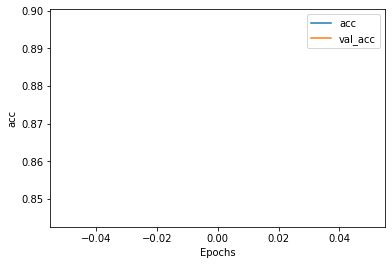

In [40]:
plot_graphs(history, 'acc')

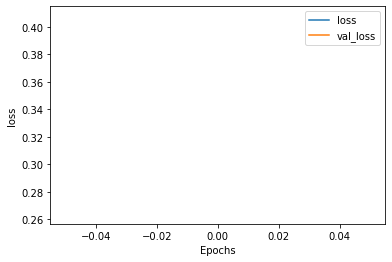

In [41]:
plot_graphs(history, 'loss')

In [49]:
# 모델 예측
text='This is joyful story'
encoded = tokenizer.encode(text)
print(encoded)
print(len(encoded))

decoded = tokenizer.decode([62, 9, 5310, 455, 250])
print(decoded)

[62, 9, 5310, 455, 250]
5
This is joyful story


In [54]:
import numpy as np

x_test = np.array([encoded])
y_predict = model.predict(x_test)

labels = ['negative', 'positive']
label = labels[1 if y_predict[0][0]>0.5 else 0]

probability = y_predict[0][0] if y_predict[0][0]>0.5 else 1-y_predict[0][0]
print(label, probability)

positive 0.86193
